In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument w

In [2]:
import gc
import torch

In [3]:
import os

## Functions

In [4]:
def read_and_qc(sample_name, path):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join='-')
    
    adata.obs['sample'] = sample_name
    
    # rename genes to ENSEMBL
    adata.var['SYMBOL'] = adata.var_names
    adata.var_names = adata.var['gene_ids']
    adata.var_names.name = None

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('MT-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

## Read in metadata

In [5]:
meta=pd.read_csv('/nfs/team205/heart/anndata_objects/Foetal/metadata/HeartTeamSamples_Mappeddata_20230208_for-cell2loc.csv',
                index_col=0)
meta

,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed,status,cell2loc-map_group
Publication,,,,,,,,,,,,,,,
Foetal,BHF_F_Hea13295830,na,Hst45,na,Heart,Heart,PCW-16w,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW
Foetal,BHF_F_Hea13295831,na,Hst45,na,Heart,Heart,PCW-16w,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW
Foetal,HCAHeartST10298114,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298115,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298116,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298117,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298118,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW_DA
Foetal,HCAHeartST10298119,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW_DA
Foetal,HCAHeartST10298120,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW


In [6]:
pd.crosstab(meta['donor'],meta['cell2loc-map_group'])

cell2loc-map_group,13PCW,20PCW,4PCW,5PCW,7PCW,7PCW_DA,FFPE_16PCW,T21_13PCW
donor,,,,,,,,
C104,0,0,1,0,0,0,0,0
C83,0,0,0,0,10,5,0,0
C92,0,0,0,2,0,0,0,0
Hst33,2,0,0,0,0,0,0,0
Hst41,0,3,0,0,0,0,0,0
Hst44,0,0,0,0,0,0,0,4
Hst45,0,0,0,0,0,0,2,0


In [7]:
# select slides
# Healthy, OCT, and without DA
meta = meta[meta['cell2loc-map_group'].isin(['4PCW','5PCW','7PCW','13PCW','20PCW'])]

sampleIDs = list(meta['sangerID'])
len(sampleIDs)

18

In [8]:
meta

,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed,status,cell2loc-map_group
Publication,,,,,,,,,,,,,,,
Foetal,HCAHeartST10298114,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298115,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298116,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298117,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298120,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10317184,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10317185,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10317186,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10317189,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW


## Data, parameters

In [9]:
run = "20Mar2024_fetal_OCT"

In [10]:
import os
results_folder = os.path.join(os.getcwd(),"analysis/Visium/cell2location_results")

ref_run_name = f'{results_folder}/reference_signatures/{run}'
run_name = f'{results_folder}/cell2location_map/{run}'


In [11]:
visium_path='/nfs/team205/heart/mapped/spaceranger110/'

celltype_key='fine_grain_modified'

vis_subset_key='cell2loc-map_group'

In [12]:
%%time
subset_values = os.listdir(os.path.join(results_folder, "cell2location_map", run))
print(f"Found these subsets {subset_values}")

for value in subset_values:
    print(f"###### {value} ######")
    adata_sub = sc.read(f"{run_name}/{value}/sp.h5ad")
    print("visium read in")
    adata_sub.obs[adata_sub.uns['mod']['factor_names']] = adata_sub.obsm['q05_cell_abundance_w_sf']
    IDs = meta[meta[vis_subset_key] == value].sangerID.tolist()
    print(f"{value}: {IDs}")

    for sample in IDs:
        try:
            slide = select_slide(adata_sub, sample)
        except IndexError as e:
            print(f"Sample {sample} not found in adata: {e}")
            continue  # Skip this sample if not found

        slide.obs[slide.uns['mod']['factor_names']] = slide.obsm['q05_cell_abundance_w_sf']
        list_of_cell_types = slide.uns['mod']['factor_names'].tolist()
        print("plotting HE image...")
        sc.pl.spatial(slide, color=None, size=0, img_key='hires', title=f"HE:{sample}", 
                      save=f"{run}__{value}__{sample}__HE.png", show=False)

        # Plotting abundances for all relevant cell states
        if list_of_cell_types:
            print("plotting abundances for all cell states...")
            sc.pl.spatial(slide, color=list_of_cell_types, cmap="RdPu", ncols=10, size=1.3, 
                          img_key='hires', vmin=0, vmax='p99.2', alpha_img=0.3, 
                          save=f"{run}__{value}__{sample}__all_cell_states_abundances.png", show=False)


Found these subsets ['5PCW', '20PCW', '13PCW', '4PCW', '7PCW']
###### 5PCW ######
visium read in
5PCW: ['HCAHeartST11605167', 'HCAHeartST11605168']


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...
###### 20PCW ######
visium read in
20PCW: ['HCAHeartST13162329', 'HCAHeartST13162330', 'HCAHeartST13162331']


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...
###### 13PCW ######
visium read in
13PCW: ['HCAHeartST11605165', 'HCAHeartST11605166']


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...
###### 4PCW ######
visium read in
4PCW: ['HCAHeartST13162332']


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...
###### 7PCW ######
visium read in
7PCW: ['HCAHeartST10298114', 'HCAHeartST10298115', 'HCAHeartST10298116', 'HCAHeartST10298117', 'HCAHeartST10298120', 'HCAHeartST10317184', 'HCAHeartST10317185', 'HCAHeartST10317186', 'HCAHeartST10317189', 'HCAHeartST10317190']


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...
plotting abundances for all cell states...
CPU times: user 9min 45s, sys: 2min 46s, total: 12min 31s
Wall time: 12min 40s


In [13]:
%%time

adata_dict={}

subset_values = os.listdir(os.path.join(results_folder, "cell2location_map", run))
print(f"Found these subsets {subset_values}")

for value in subset_values:
    print(f"###### {value} ######")
    adata_sub = sc.read(f"{run_name}/{value}/sp.h5ad")
    print("visium read in")
    adata_sub.obs[adata_sub.uns['mod']['factor_names']] = adata_sub.obsm['q05_cell_abundance_w_sf']
    IDs = meta[meta[vis_subset_key] == value].sangerID.tolist()
    print(f"{value}: {IDs}")

    for sample in IDs:
        try:
            slide = select_slide(adata_sub, sample)
        except IndexError as e:
            print(f"Sample {sample} not found in adata: {e}")
            continue  # Skip this sample if not found

        slide.obs[slide.uns['mod']['factor_names']] = slide.obsm['q05_cell_abundance_w_sf']
        adata_dict[sample]=slide

Found these subsets ['5PCW', '20PCW', '13PCW', '4PCW', '7PCW']
###### 5PCW ######
visium read in
5PCW: ['HCAHeartST11605167', 'HCAHeartST11605168']


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


###### 20PCW ######
visium read in
20PCW: ['HCAHeartST13162329', 'HCAHeartST13162330', 'HCAHeartST13162331']


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


###### 13PCW ######
visium read in
13PCW: ['HCAHeartST11605165', 'HCAHeartST11605166']


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


###### 4PCW ######
visium read in
4PCW: ['HCAHeartST13162332']


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


###### 7PCW ######
visium read in
7PCW: ['HCAHeartST10298114', 'HCAHeartST10298115', 'HCAHeartST10298116', 'HCAHeartST10298117', 'HCAHeartST10298120', 'HCAHeartST10317184', 'HCAHeartST10317185', 'HCAHeartST10317186', 'HCAHeartST10317189', 'HCAHeartST10317190']


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view

CPU times: user 3.58 s, sys: 8.52 s, total: 12.1 s
Wall time: 18.3 s


In [14]:
adata_dict.keys()

dict_keys(['HCAHeartST11605167', 'HCAHeartST11605168', 'HCAHeartST13162329', 'HCAHeartST13162330', 'HCAHeartST13162331', 'HCAHeartST11605165', 'HCAHeartST11605166', 'HCAHeartST13162332', 'HCAHeartST10298114', 'HCAHeartST10298115', 'HCAHeartST10298116', 'HCAHeartST10298117', 'HCAHeartST10298120', 'HCAHeartST10317184', 'HCAHeartST10317185', 'HCAHeartST10317186', 'HCAHeartST10317189', 'HCAHeartST10317190'])

In [55]:
from tqdm import tqdm
atrial_data_dict={}
for sample,tmp_adata in tqdm(adata_dict.items()):
    print(f"sample: {sample},  age is {tmp_adata.obs.age.unique().tolist()[0]}")
    tmp_df=tmp_adata[tmp_adata.obs.JC_edit=="Myocardium - Atrial"].obs[['AtrialCardiomyocytesLeft_immature', 'AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight','AtrialCardiomyocytesRight_immature']]

    if tmp_df.shape[0]>0:
        tmp_df["sample"]=sample
        tmp_df["age"]=tmp_adata.obs.age.unique().tolist()[0]
        atrial_data_dict[sample]=tmp_df
    else:
        print(f"no atrial myocardium spots annotated for sample: {sample}")

  0%|                                                                                                                                                                                                                    | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_167807/3397130741.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df["sample"]=sample
/tmp/ipykernel_167807/3397130741.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df["age"]=tmp_adata.obs.age.unique().tolist()[0]
/tmp/ipykernel_167807/339

sample: HCAHeartST11605167,  age is GA-7w4d
sample: HCAHeartST11605168,  age is GA-7w4d
sample: HCAHeartST13162329,  age is PCW-20w
no atrial myocardium spots annotated for sample: HCAHeartST13162329
sample: HCAHeartST13162330,  age is PCW-20w
no atrial myocardium spots annotated for sample: HCAHeartST13162330
sample: HCAHeartST13162331,  age is PCW-20w
no atrial myocardium spots annotated for sample: HCAHeartST13162331
sample: HCAHeartST11605165,  age is PCW-13w
sample: HCAHeartST11605166,  age is PCW-13w
sample: HCAHeartST13162332,  age is GA-6w3d
no atrial myocardium spots annotated for sample: HCAHeartST13162332
sample: HCAHeartST10298114,  age is GA-9w4d
sample: HCAHeartST10298115,  age is GA-9w4d
sample: HCAHeartST10298116,  age is GA-9w4d
sample: HCAHeartST10298117,  age is GA-9w4d
sample: HCAHeartST10298120,  age is GA-9w4d
sample: HCAHeartST10317184,  age is GA-9w4d
sample: HCAHeartST10317185,  age is GA-9w4d
sample: HCAHeartST10317186,  age is GA-9w4d
sample: HCAHeartST103171

In [56]:
data=pd.concat(list(atrial_data_dict.values()))
data

,AtrialCardiomyocytesLeft_immature,AtrialCardiomyocytesLeft,AtrialCardiomyocytesRight,AtrialCardiomyocytesRight_immature,sample,age
spot_id,,,,,,
HCAHeartST11605167_AAACATTTCCCGGATT-1,1.877678,0.345141,0.201719,0.535715,HCAHeartST11605167,GA-7w4d
HCAHeartST11605167_AAGCGCAGGGCTTTGA-1,1.138855,2.983185,0.096187,0.440762,HCAHeartST11605167,GA-7w4d
HCAHeartST11605167_AATTCGATTCGAGGAT-1,2.191962,6.975332,0.044196,0.464511,HCAHeartST11605167,GA-7w4d
HCAHeartST11605167_ACAAAGCATGACCTAG-1,1.428606,0.542499,0.551390,1.014553,HCAHeartST11605167,GA-7w4d
HCAHeartST11605167_ACCAACCGCACTCCAC-1,1.174236,0.891836,0.558041,1.258697,HCAHeartST11605167,GA-7w4d
...,...,...,...,...,...,...
HCAHeartST10317190_TGGTCTAGCTTACATG-1,2.183361,9.425388,0.515929,0.417190,HCAHeartST10317190,GA-9w4d
HCAHeartST10317190_TGGTTATGCTTGCGGT-1,1.167605,4.389519,0.295015,0.253649,HCAHeartST10317190,GA-9w4d
HCAHeartST10317190_TTAACTCACGCGTGGA-1,0.027100,0.025974,0.030167,0.014092,HCAHeartST10317190,GA-9w4d


In [57]:
data.to_csv("AtrialProportionsOCT.csv")

In [49]:
# Assuming 'data' is your pandas DataFrame
# Calculate the total for each row
total = data['AtrialCardiomyocytesLeft_immature'] + data['AtrialCardiomyocytesLeft'] + data['AtrialCardiomyocytesRight'] + data['AtrialCardiomyocytesRight_immature']

# Calculate the proportions for each column
data['AtrialCardiomyocytesRight_immature_prop'] = data['AtrialCardiomyocytesRight_immature'] / total
data['AtrialCardiomyocytesLeft_immature_prop'] = data['AtrialCardiomyocytesLeft_immature'] / total
data['AtrialCardiomyocytesRight_prop'] = data['AtrialCardiomyocytesRight'] / total
data['AtrialCardiomyocytesLeft_prop'] = data['AtrialCardiomyocytesLeft'] / total

# The new DataFrame 'data' now includes the proportion columns
data

,AtrialCardiomyocytesLeft_immature,AtrialCardiomyocytesLeft,AtrialCardiomyocytesRight,AtrialCardiomyocytesRight_immature,sample,age,AtrialCardiomyocytesRight_immature_prop,AtrialCardiomyocytesLeft_immature_prop,AtrialCardiomyocytesRight_prop,AtrialCardiomyocytesLeft_prop
spot_id,,,,,,,,,,
HCAHeartST11605167_AAACATTTCCCGGATT-1,1.877678,0.345141,0.201719,0.535715,HCAHeartST11605167,GA-7w4d,0.180969,0.634297,0.068142,0.116592
HCAHeartST11605167_AAGCGCAGGGCTTTGA-1,1.138855,2.983185,0.096187,0.440762,HCAHeartST11605167,GA-7w4d,0.094605,0.244443,0.020645,0.640307
HCAHeartST11605167_AATTCGATTCGAGGAT-1,2.191962,6.975332,0.044196,0.464511,HCAHeartST11605167,GA-7w4d,0.048007,0.226536,0.004568,0.720890
HCAHeartST11605167_ACAAAGCATGACCTAG-1,1.428606,0.542499,0.551390,1.014553,HCAHeartST11605167,GA-7w4d,0.286836,0.403898,0.155890,0.153376
HCAHeartST11605167_ACCAACCGCACTCCAC-1,1.174236,0.891836,0.558041,1.258697,HCAHeartST11605167,GA-7w4d,0.324172,0.302419,0.143721,0.229688
...,...,...,...,...,...,...,...,...,...,...
HCAHeartST10317190_TGGTCTAGCTTACATG-1,2.183361,9.425388,0.515929,0.417190,HCAHeartST10317190,GA-9w4d,0.033264,0.174086,0.041137,0.751514
HCAHeartST10317190_TGGTTATGCTTGCGGT-1,1.167605,4.389519,0.295015,0.253649,HCAHeartST10317190,GA-9w4d,0.041542,0.191229,0.048317,0.718911
HCAHeartST10317190_TTAACTCACGCGTGGA-1,0.027100,0.025974,0.030167,0.014092,HCAHeartST10317190,GA-9w4d,0.144782,0.278428,0.309934,0.266856


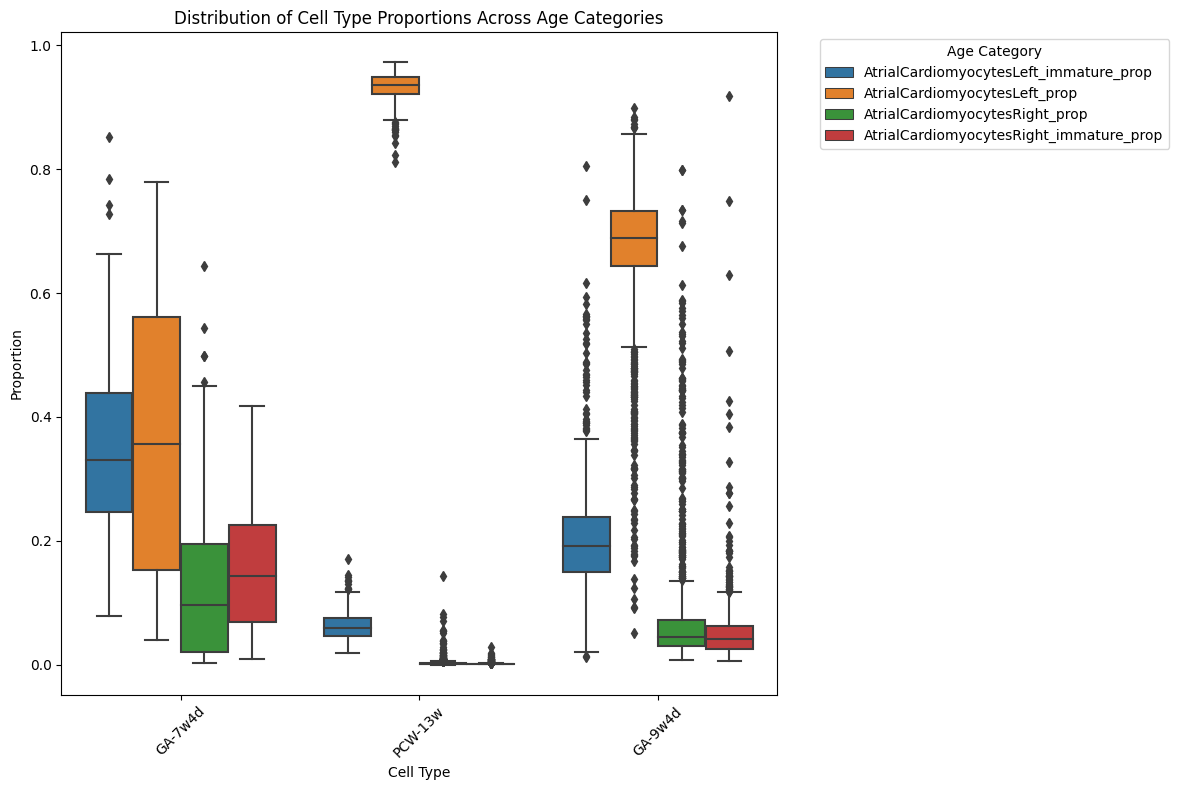

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and it already includes an 'age' column
df_long = data.melt(id_vars='age', var_name='Cell Type', value_name='Proportion', 
                    value_vars=['AtrialCardiomyocytesLeft_immature_prop', 'AtrialCardiomyocytesLeft_prop', 
                                'AtrialCardiomyocytesRight_prop', 'AtrialCardiomyocytesRight_immature_prop'])

# Create the box plot with 'hue' for age categories
plt.figure(figsize=(12, 8))
sns.boxplot(x='age', y='Proportion', hue='Cell Type', data=df_long)
plt.title('Distribution of Cell Type Proportions Across Age Categories')
plt.xticks(rotation=45)
plt.xlabel('Cell Type')
plt.ylabel('Proportion')
plt.legend(title='Age Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [51]:
# Assuming 'data' is your pandas DataFrame
# Calculate the total for Left and Right cells separately
total_left = data['AtrialCardiomyocytesLeft_immature'] + data['AtrialCardiomyocytesLeft']
total_right = data['AtrialCardiomyocytesRight_immature'] + data['AtrialCardiomyocytesRight']

# Calculate the proportions for each cell type relative to their side
data['AtrialCardiomyocytesLeft_immature_prop'] = data['AtrialCardiomyocytesLeft_immature'] / total_left
data['AtrialCardiomyocytesLeft_prop'] = data['AtrialCardiomyocytesLeft'] / total_left

data['AtrialCardiomyocytesRight_immature_prop'] = data['AtrialCardiomyocytesRight_immature'] / total_right
data['AtrialCardiomyocytesRight_prop'] = data['AtrialCardiomyocytesRight'] / total_right

# Check the new columns in the DataFrame
data[['AtrialCardiomyocytesLeft_immature_prop', 'AtrialCardiomyocytesLeft_prop', 'AtrialCardiomyocytesRight_immature_prop', 'AtrialCardiomyocytesRight_prop']]

import numpy as np

data['AtrialCardiomyocytesLeft_immature_prop'] = np.where(total_left == 0, 0, data['AtrialCardiomyocytesLeft_immature'] / total_left)
data['AtrialCardiomyocytesLeft_prop'] = np.where(total_left == 0, 0, data['AtrialCardiomyocytesLeft'] / total_left)

data['AtrialCardiomyocytesRight_immature_prop'] = np.where(total_right == 0, 0, data['AtrialCardiomyocytesRight_immature'] / total_right)
data['AtrialCardiomyocytesRight_prop'] = np.where(total_right == 0, 0, data['AtrialCardiomyocytesRight'] / total_right)
data

,AtrialCardiomyocytesLeft_immature,AtrialCardiomyocytesLeft,AtrialCardiomyocytesRight,AtrialCardiomyocytesRight_immature,sample,age,AtrialCardiomyocytesRight_immature_prop,AtrialCardiomyocytesLeft_immature_prop,AtrialCardiomyocytesRight_prop,AtrialCardiomyocytesLeft_prop
spot_id,,,,,,,,,,
HCAHeartST11605167_AAACATTTCCCGGATT-1,1.877678,0.345141,0.201719,0.535715,HCAHeartST11605167,GA-7w4d,0.726459,0.844728,0.273541,0.155272
HCAHeartST11605167_AAGCGCAGGGCTTTGA-1,1.138855,2.983185,0.096187,0.440762,HCAHeartST11605167,GA-7w4d,0.820865,0.276284,0.179135,0.723716
HCAHeartST11605167_AATTCGATTCGAGGAT-1,2.191962,6.975332,0.044196,0.464511,HCAHeartST11605167,GA-7w4d,0.913121,0.239107,0.086879,0.760893
HCAHeartST11605167_ACAAAGCATGACCTAG-1,1.428606,0.542499,0.551390,1.014553,HCAHeartST11605167,GA-7w4d,0.647886,0.724774,0.352114,0.275226
HCAHeartST11605167_ACCAACCGCACTCCAC-1,1.174236,0.891836,0.558041,1.258697,HCAHeartST11605167,GA-7w4d,0.692834,0.568342,0.307166,0.431658
...,...,...,...,...,...,...,...,...,...,...
HCAHeartST10317190_TGGTCTAGCTTACATG-1,2.183361,9.425388,0.515929,0.417190,HCAHeartST10317190,GA-9w4d,0.447092,0.188079,0.552908,0.811921
HCAHeartST10317190_TGGTTATGCTTGCGGT-1,1.167605,4.389519,0.295015,0.253649,HCAHeartST10317190,GA-9w4d,0.462303,0.210110,0.537697,0.789890
HCAHeartST10317190_TTAACTCACGCGTGGA-1,0.027100,0.025974,0.030167,0.014092,HCAHeartST10317190,GA-9w4d,0.318401,0.510611,0.681599,0.489389


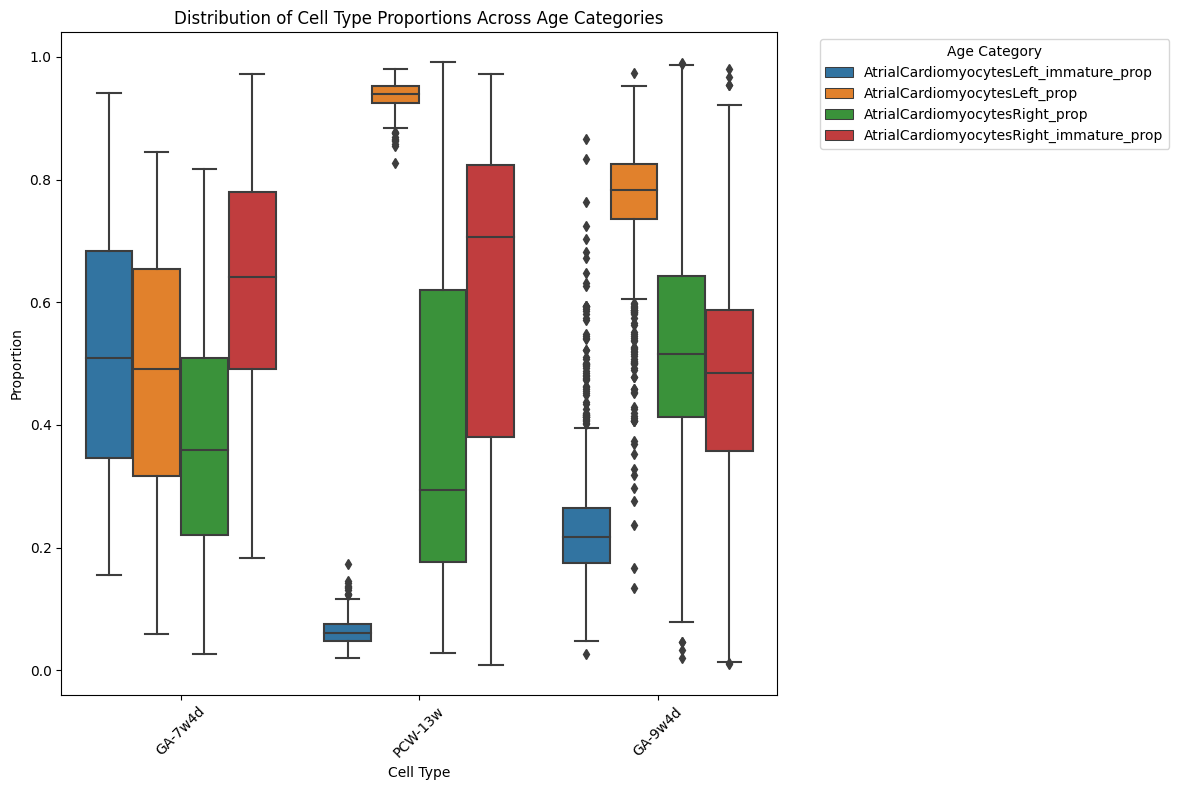

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and it already includes an 'age' column
df_long = data.melt(id_vars='age', var_name='Cell Type', value_name='Proportion', 
                    value_vars=['AtrialCardiomyocytesLeft_immature_prop', 'AtrialCardiomyocytesLeft_prop', 
                                'AtrialCardiomyocytesRight_prop', 'AtrialCardiomyocytesRight_immature_prop'])

# Create the box plot with 'hue' for age categories
plt.figure(figsize=(12, 8))
sns.boxplot(x='age', y='Proportion', hue='Cell Type', data=df_long)
plt.title('Distribution of Cell Type Proportions Across Age Categories')
plt.xticks(rotation=45)
plt.xlabel('Cell Type')
plt.ylabel('Proportion')
plt.legend(title='Age Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
